# LunarLander using Actor-Critic Method

The goal of this assignment is to implement and understand the Actor-Critic reinforcement learning algorithm to
 solve the LunarLander-v3 environment from OpenAI Gymnasium.

## Implementation

### Setup

- Install required libraries if not already isntalled.
- Uncomment the below cell and run it

In [ ]:
#!pip install gymnasium[box2d] numpy torch matplotlib

#### Import libraries

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random

#set up a random seeds for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

#Check the CUDA is available to compute or use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available:", device)

Device available: cpu


### Environment exploration

In [2]:
env = gym.make("LunarLander-v2", render_mode="human")

#Explore state space 
print("State space:", env.observation_space)
print("\nState Dimension:", env.observation_space.shape[0])

#Explore action space 
print("\nAction space:", env.action_space)
print("Number of Actions:", env.action_space.n)

#env on human mode
obs, info = env.reset()
episode_reward = 0
episode_count = 0

print("\nTesting environment with random policy")
for step in range(500):
    action = env.action_space.sample()   # take random actions
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward

    if terminated or truncated:
        episode_count += 1
        print(f"Episode {episode_count} | Reward: {episode_reward}")
        episode_reward = 0
        obs, info = env.reset()

env.close()
print("Completed")

State space: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)

State Dimension: 8

Action space: Discrete(4)
Number of Actions: 4

Testing environment with random policy
Episode 1 | Reward: -63.87668835920314
Episode 2 | Reward: -121.56064149695013
Episode 3 | Reward: -282.3688785877381
Episode 4 | Reward: 16.15545526678565
Episode 5 | Reward: -128.97652391613096
Completed


### Actor and Critic Networks

In [3]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()

        #3 layer network
        #128 = hidden dimension
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

In [4]:
class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()

        #3 layer network
        #128 = hidden dimension
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

        self.relu = nn.ReLU()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        state_value = self.fc3(x)
        return state_value


#initialize dim
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n

actor = ActorNetwork(STATE_DIM, ACTION_DIM)
critic = CriticNetwork(STATE_DIM)

print("Actor Network:\n")
print(f"Input dim {STATE_DIM} | Hidden dim {128} | Action dim {ACTION_DIM}")
print(f"Total Parameters: {sum(p.numel() for p in actor.parameters())}")

print("\nCritic Network:\n")
print(f"Input dim {STATE_DIM} | Hidden dim {128} | Action dim {1}")
print(f"Total Parameters: {sum(p.numel() for p in critic.parameters())}")

Actor Network:

Input dim 8 | Hidden dim 128 | Action dim 4
Total Parameters: 18180

Critic Network:

Input dim 8 | Hidden dim 128 | Action dim 1
Total Parameters: 17793


### Policy and Value Estimation

In [5]:
def select_action(state, actor):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)

    #get action prob from actor 
    action_probs = actor(state_tensor)

    #sample action from prob dist
    dist = torch.distributions.Categorical(action_probs)
    action = dist.sample()
    log_prob = dist.log_prob(action)

    return action.item(), log_prob


def get_value(state, critic):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    value = critic(state_tensor)
    return value


#Test 
test_state = np.random.randn(STATE_DIM)
test_action, test_log_prob = select_action(test_state, actor)
test_value = get_value(test_state, critic)

print("Test using random state")
print(f"Selected Action: {test_action} | Log Prob: {test_log_prob.item():.4f} | State Value: {test_value.item():.4f}")    

Test using random state
Selected Action: 1 | Log Prob: -1.4539 | State Value: -0.4261


### Training Loop

In [6]:
#Hyperparameters 
lr_actor = 0.0003
lr_critic = 0.001
g = 0.99  #discount factor
n_ep = 1000
max_steps = 1000

#optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr_actor)
critic_opt = optim.Adam(critic.parameters(), lr=lr_critic)

#result storage
ep_rewards = []
ep_lengths = []
running_reward = deque(maxlen=100)

#setup environment for training 
env = gym.make("LunarLander-v2")

print("Start Training\n")

for ep in range(n_ep):  #1000
    state, info = env.reset(seed=SEED + ep)
    ep_reward = 0
    ep_length = 0

    for step in range(max_steps):
        #select action usign current policy
        action, log_prob = select_action(state, actor)

        state_tensor = torch.FloatTensor(state)

        #get current state value
        state_value = critic(state_tensor)

        #take action in env
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state_tensor = torch.FloatTensor(next_state)
        next_state_value = critic(next_state_tensor) #get next state

        #calculate TD error - advantage
        reward_tensor = torch.FloatTensor([reward])
        done_mask = 0.0 if done else 1.0
        td_target = reward_tensor + g * next_state_value * done_mask
        advantage = td_target - state_value

        #update critic - minimize MSE of value estimates
        critic_opt.zero_grad()
        critic_loss = advantage.pow(2)
        critic_loss.backward()
        critic_opt.step()

        #update actor - policy gradient 
        actor_opt.zero_grad()
        actor_loss = -log_prob * advantage.detach()
        actor_loss.backward()
        actor_opt.step()

        #update state and counters
        state = next_state
        ep_reward += reward
        ep_length += 1

        if done:
            break

    #store the result
    ep_rewards.append(ep_reward)
    ep_lengths.append(ep_length)
    running_reward.append(ep_reward)

    #Print progress
    if (ep + 1) % 50 == 0:
        avg_reward = np.mean(running_reward)
        print(f"Episode: {ep + 1}/{n_ep} | Avg Reward (last 100): {avg_reward:.2f} | Episode Reward: {ep_reward:.2f}")

env.close()

print("Training Done\n")

Start Training

Episode: 50/1000 | Avg Reward (last 100): -172.15 | Episode Reward: -198.92
Episode: 100/1000 | Avg Reward (last 100): -98.07 | Episode Reward: -30.11
Episode: 150/1000 | Avg Reward (last 100): 3.72 | Episode Reward: -17.19
Episode: 200/1000 | Avg Reward (last 100): 35.83 | Episode Reward: -124.62
Episode: 250/1000 | Avg Reward (last 100): 14.21 | Episode Reward: 145.10
Episode: 300/1000 | Avg Reward (last 100): -6.92 | Episode Reward: -60.46
Episode: 350/1000 | Avg Reward (last 100): -7.18 | Episode Reward: -129.66
Episode: 400/1000 | Avg Reward (last 100): 4.19 | Episode Reward: 259.93
Episode: 450/1000 | Avg Reward (last 100): 72.95 | Episode Reward: -136.66
Episode: 500/1000 | Avg Reward (last 100): 139.88 | Episode Reward: 17.11
Episode: 550/1000 | Avg Reward (last 100): 160.87 | Episode Reward: 224.58
Episode: 600/1000 | Avg Reward (last 100): 138.11 | Episode Reward: 207.34
Episode: 650/1000 | Avg Reward (last 100): 108.40 | Episode Reward: 168.59
Episode: 700/10

### Evaluation and Testing

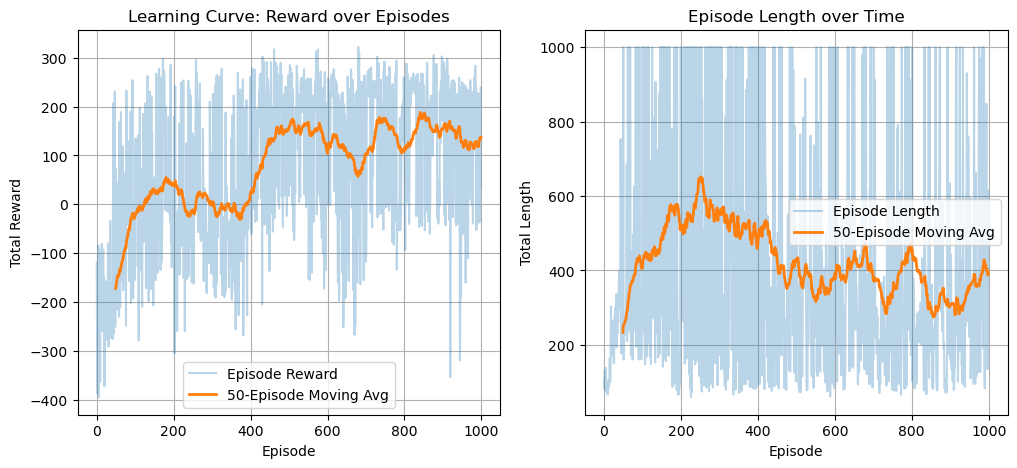

Learning curve saved


In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ep_rewards, alpha=0.3, label='Episode Reward')

#Calculate moving avg
window = 50
moving_avg = np.convolve(ep_rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(ep_rewards)), moving_avg, label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve: Reward over Episodes')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ep_lengths, alpha=0.3, label='Episode Length')
moving_avg_ln = np.convolve(ep_lengths, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(ep_lengths)), moving_avg_ln, label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Length')
plt.title('Episode Length over Time')
plt.legend()
plt.grid(True)

# plt.tight_layout()
# plt.savefig('learning_curve.png')
plt.show()
print("Learning curve saved")

### Evaluate trained agent

In [9]:
n_ep_eval = 20
env = gym.make("LunarLander-v2")

actor.eval()
critic.eval()

trained_rewards = []

for ep in range(n_ep_eval):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action, _ = select_action(state, actor)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

    trained_rewards.append(total_reward)
    print(f"Evaluation Episode {ep + 1}: Reward = {total_reward:.2f}")

env.close()

print(f"\n Trained Agent: {np.mean(trained_rewards):.2f} ± {np.std(trained_rewards):.2f}")

Evaluation Episode 1: Reward = 247.36
Evaluation Episode 2: Reward = -166.69
Evaluation Episode 3: Reward = 177.07
Evaluation Episode 4: Reward = -52.98
Evaluation Episode 5: Reward = 235.54
Evaluation Episode 6: Reward = 6.44
Evaluation Episode 7: Reward = 148.17
Evaluation Episode 8: Reward = 118.71
Evaluation Episode 9: Reward = 84.66
Evaluation Episode 10: Reward = -194.52
Evaluation Episode 11: Reward = -7.39
Evaluation Episode 12: Reward = -14.19
Evaluation Episode 13: Reward = 117.26
Evaluation Episode 14: Reward = -203.91
Evaluation Episode 15: Reward = 68.21
Evaluation Episode 16: Reward = 265.86
Evaluation Episode 17: Reward = 112.14
Evaluation Episode 18: Reward = 171.15
Evaluation Episode 19: Reward = -102.60
Evaluation Episode 20: Reward = 2.53

 Trained Agent: 50.64 ± 139.95


### Test Random Policy

In [11]:
env = gym.make("LunarLander-v2")
random_rewards = []

for ep in range(20):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

    random_rewards.append(total_reward)
    print(f"Evaluation Episode {ep + 1}: Reward = {total_reward:.2f}")
    
env.close()

print(f"\n Random Policy: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")

Evaluation Episode 1: Reward = -258.95
Evaluation Episode 2: Reward = -177.87
Evaluation Episode 3: Reward = -102.50
Evaluation Episode 4: Reward = -68.58
Evaluation Episode 5: Reward = -137.38
Evaluation Episode 6: Reward = -101.88
Evaluation Episode 7: Reward = -102.44
Evaluation Episode 8: Reward = -144.38
Evaluation Episode 9: Reward = -142.97
Evaluation Episode 10: Reward = -83.66
Evaluation Episode 11: Reward = -132.43
Evaluation Episode 12: Reward = -279.14
Evaluation Episode 13: Reward = -188.81
Evaluation Episode 14: Reward = -478.75
Evaluation Episode 15: Reward = -344.21
Evaluation Episode 16: Reward = -121.77
Evaluation Episode 17: Reward = -331.18
Evaluation Episode 18: Reward = -61.20
Evaluation Episode 19: Reward = -122.94
Evaluation Episode 20: Reward = -250.14

 Random Policy: -181.56 ± 106.63


### Comparison plot

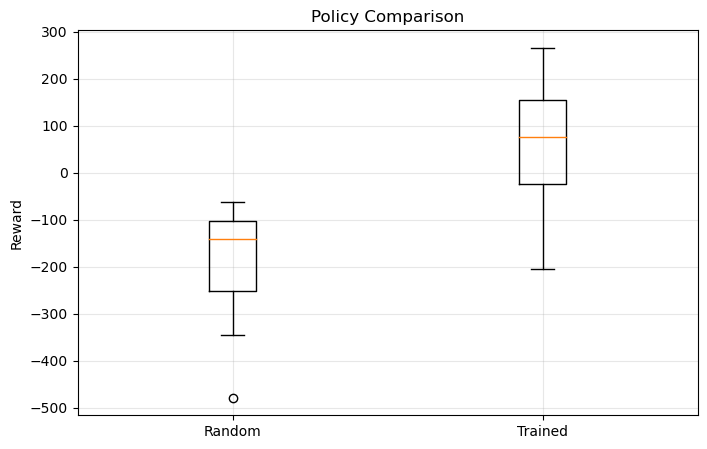

In [12]:
plt.figure(figsize=(8,5))
plt.boxplot([random_rewards, trained_rewards], labels=['Random', 'Trained'])
plt.ylabel('Reward')
plt.title('Policy Comparison')
plt.grid(True, alpha=0.3)
#plt.savefig('comparison.png')
plt.show()
#print("Comparison plot saved")

### Summary Improvement

In [13]:
improvement = np.mean(trained_rewards) - np.mean(random_rewards)

print(f"Improvement: {improvement:.2f} points ({improvement/abs(np.mean(random_rewards))*100:.1f}%)")

Improvement: 232.20 points (127.9%)


### Visualize the trained agent

In [17]:
env = gym.make("LunarLander-v2", render_mode="human")

actor.eval()

n_demo = 10

for ep in range(n_demo):
    state, info = env.reset()
    total_rwd = 0
    done = False
    steps = 0

    print(f"Episode {ep + 1}..")

    while not done:
        with torch.no_grad():
            action, _ = select_action(state, actor)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_rwd += reward
        steps += 1

    print(f"Episode {ep + 1} | Reward: {total_rwd:.2f} | Steps: {steps}")

env.close()
print("Done")

Episode 1..
Episode 1 | Reward: 98.43 | Steps: 871
Episode 2..
Episode 2 | Reward: 132.76 | Steps: 693
Episode 3..
Episode 3 | Reward: -14.48 | Steps: 1000
Episode 4..
Episode 4 | Reward: 64.81 | Steps: 1000
Episode 5..
Episode 5 | Reward: -76.40 | Steps: 1000
Episode 6..
Episode 6 | Reward: -330.32 | Steps: 978
Episode 7..
Episode 7 | Reward: 96.34 | Steps: 946
Episode 8..
Episode 8 | Reward: -29.48 | Steps: 1000
Episode 9..
Episode 9 | Reward: -258.05 | Steps: 502
Episode 10..
Episode 10 | Reward: 138.39 | Steps: 582
Done
